for CO2_parametrization of VPRM old
Series([], dtype: float64)
Number of deleted site years due to R2_NEE < 0 = 1
y = 1.03x + 10.35


/tmp/ipykernel_3902075/1929688540.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
/tmp/ipykernel_3902075/1929688540.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
/tmp/ipykernel_3902075/1929688540.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
/tmp/ipykernel_3902075/1929688540.py:264: FutureWarning: 

Passing `palette`

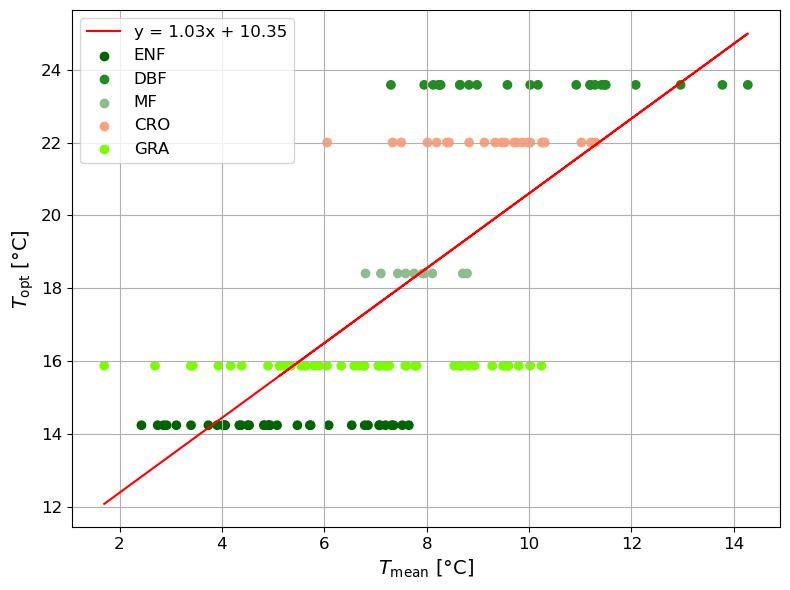

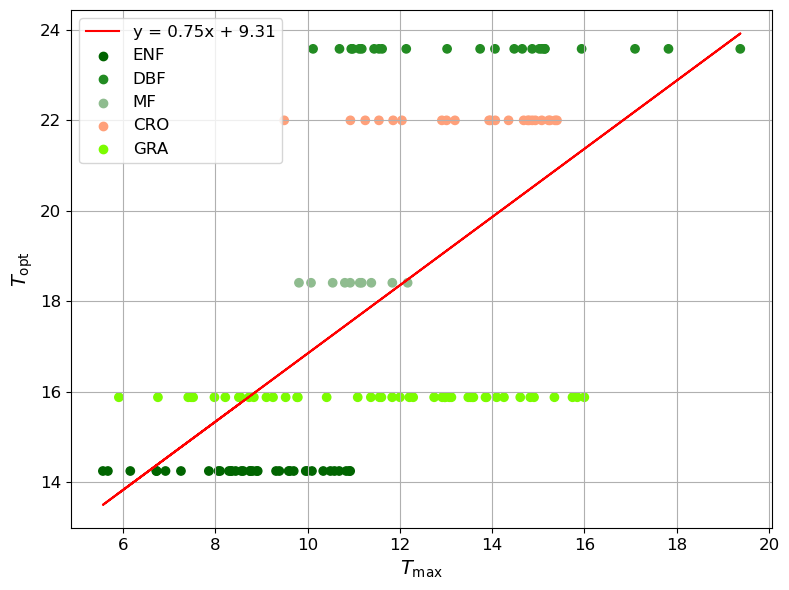

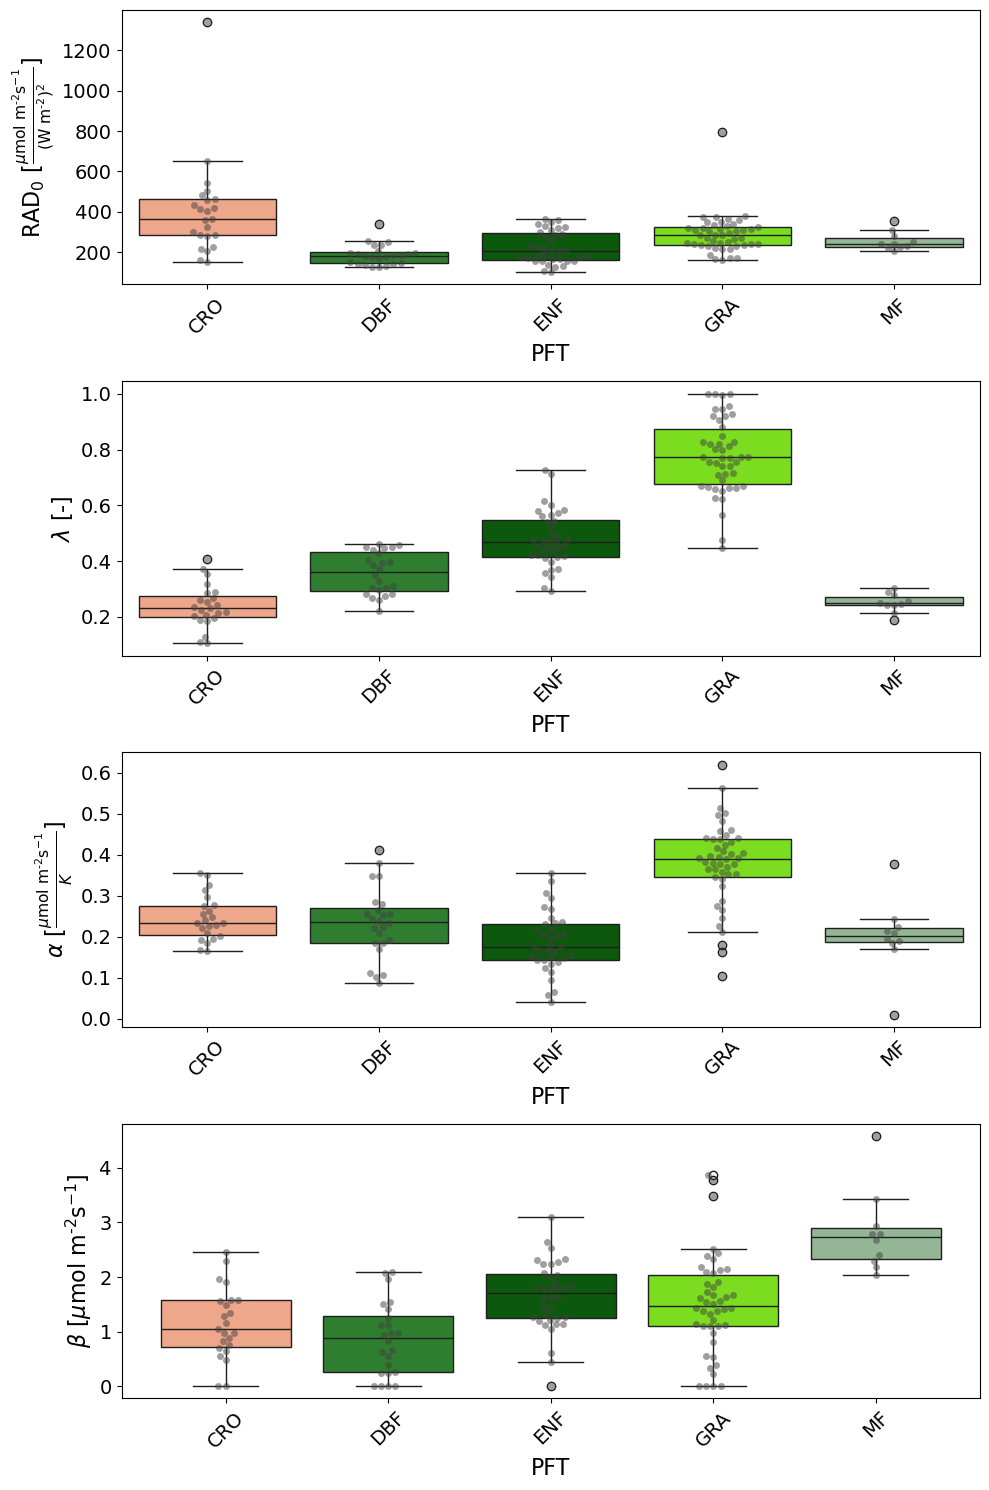

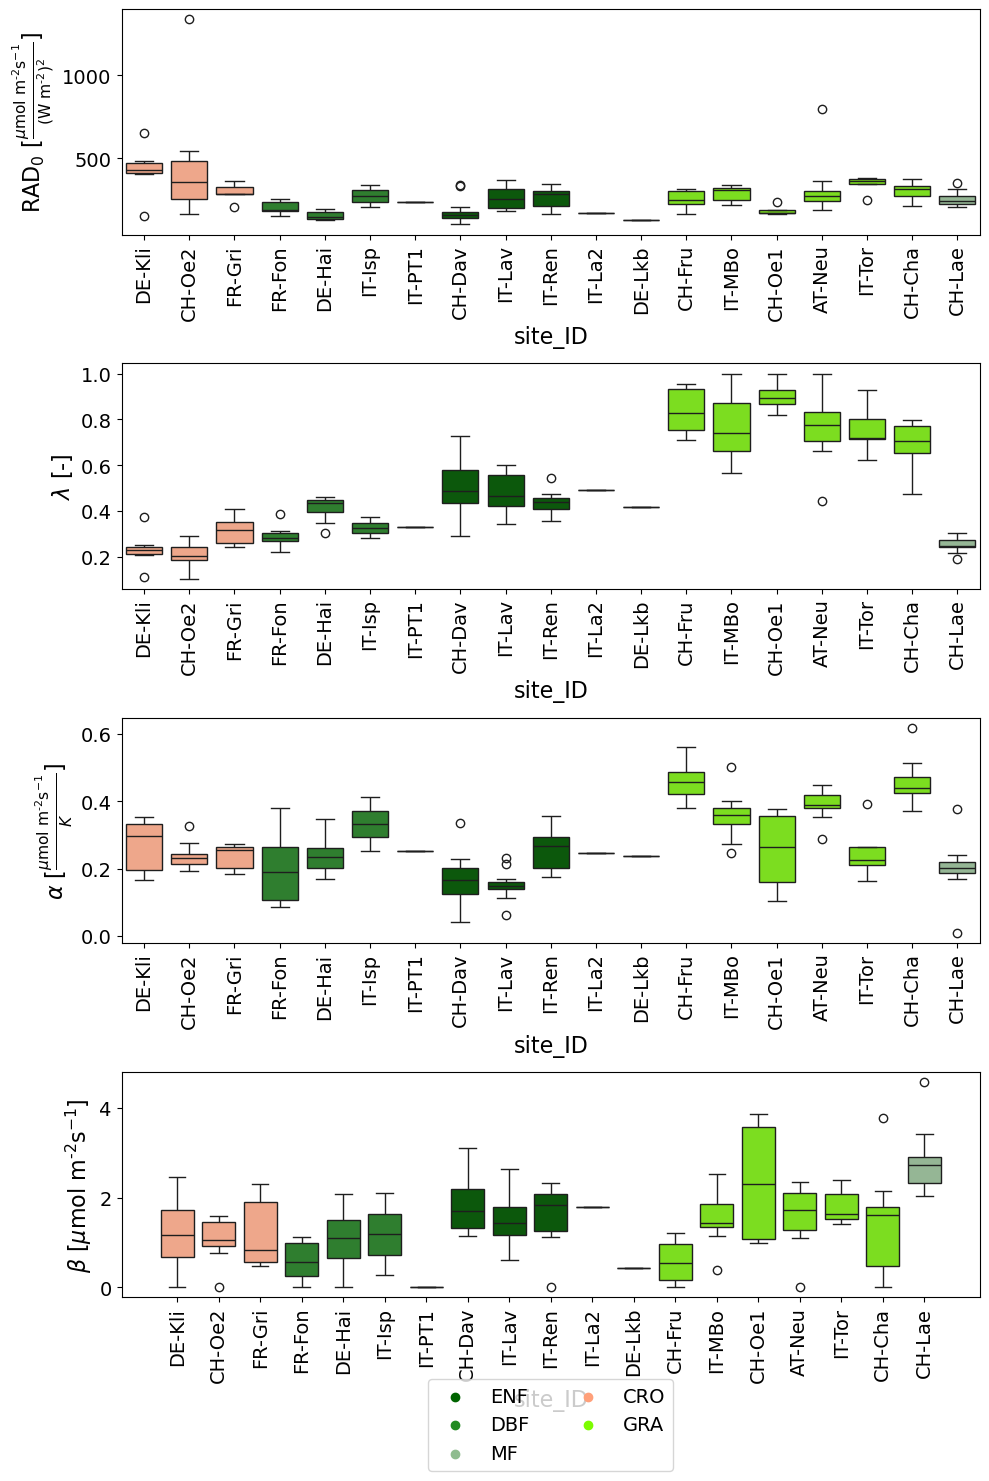

/tmp/ipykernel_3902075/1929688540.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
/tmp/ipykernel_3902075/1929688540.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_3902075/1929688540.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in

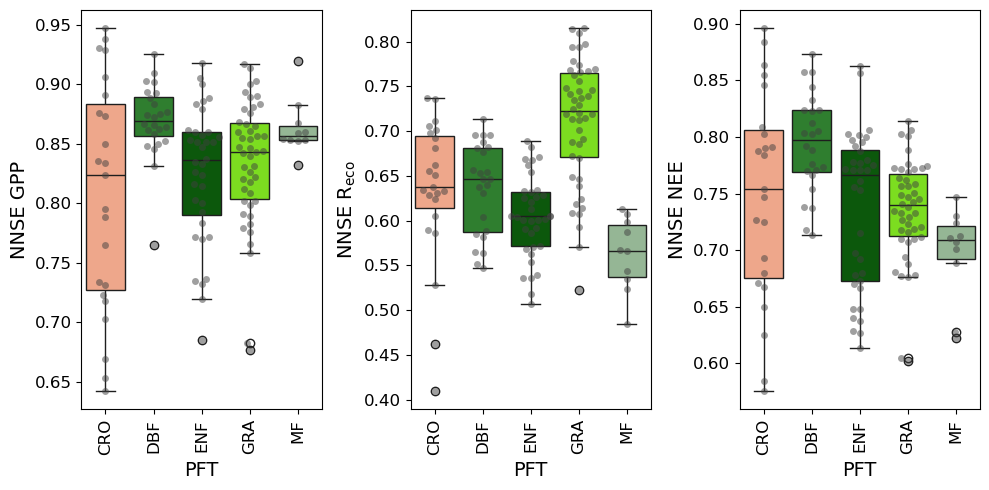

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

version = "V23"
iterations = "42"
R2_lt_zero = True # test so see results for R2_lt_zero - default: True (deletes sites below zero R2) 


# European default values
columns = ['ENF', 'DBF', 'MF', 'SHB','SAV', 'CRO', 'GRA', 'OTH']

# Define the data (4 rows)
data = [
    [270.2, 271.4, 236.6, 363.0, 682.0, 690.3, 229.1, 0.0],
    [0.1797, 0.1495, 0.2258, 0.0239, 0.0049, 0.1699, 0.0881, 0.0000],
    [0.8800, 0.8233, 0.4321, 0.0000, 0.0000, -0.0144, 0.5843, 0.0000],
    [0.3084, 0.1955, 0.2856, 0.0874, 0.1141, 0.1350, 0.1748, 0.0000]
]

# Create the DataFrame
europe_pars = pd.DataFrame(data, columns=columns)

# Add row labels for the parameters
europe_pars.index = ['RAD0', 'alpha', 'beta', 'lambd']

for CO2_parametrization in ["old"]: # "migli","old","new"
    for region in ["Alps"]: # ,"Europe"
        run_ID = region+"_VPRM_optimized_params_diff_evo_"+version+"_"+iterations

        base_path = "/scratch/c7071034/DATA/Fluxnet2015/Alps/"
        plot_path = "/home/c707/c7071034/Github/WRF_VPRM_post/plots"
        
        if CO2_parametrization == "migli":
            print(f"for CO2_parametrization of Migliavacca")
        else:
            print(f"for CO2_parametrization of VPRM {CO2_parametrization}")

        folders = [
            f
            for f in os.listdir(base_path)
            if os.path.isdir(os.path.join(base_path, f))
        ]
        flx_folders = [folder for folder in folders if folder.startswith("FLX_")]

        if not flx_folders:
            print("Warning - There is no input data")
            raise SystemExit(0)

        df_parameters = pd.DataFrame()


        # Loop through each FLX_ folder and append data from XLSX files
        for folder in flx_folders:
            folder_path = os.path.join(base_path, folder)
            files = [f for f in os.listdir(folder_path) if f.endswith(CO2_parametrization+'_diff_evo_'+version+'_'+iterations+'.xlsx')]
            for file in files:
                file_path = os.path.join(folder_path, file)
                data = pd.read_excel(file_path)
                df_parameters = pd.concat([df_parameters, data], axis=0)
        # rename column from df_parameters "PAR0" to "RAD0"
        df_parameters.rename(columns={"PAR0": "RAD0"}, inplace=True) #TODO: adopt this in VPRM code

        # folders = [
        #     f
        #     for f in os.listdir(base_path)
        #     if os.path.isdir(os.path.join(base_path, f))
        # ]
        # flx_folders = [folder for folder in folders if folder.startswith("FLX_")]

        # if not flx_folders:
        #     print("Warning - There is no input data")
        #     raise SystemExit(0)        
        # df_parameters = pd.DataFrame()
        # # Loop through each FLX_ folder and append data from XLSX files
        # for folder in flx_folders:
        #     folder_path = os.path.join(base_path, folder)
        #     files = [f for f in os.listdir(folder_path) if f.endswith(CO2_parametrization+'_diff_evo_'+version+'_'+iterations+'.xlsx')]
        #     for file in files:
        #         file_path = os.path.join(folder_path, file)
        #         data = pd.read_excel(file_path)
        #         df_parameters = pd.concat([df_parameters, data], axis=0)


        df_parameters_nn = df_parameters.copy()
        df_parameters_nn = df_parameters_nn.dropna()
        font_size = 12
        custom_colors = ["#006400", "#228B22", "#8FBC8F", "#A0522D", 
                 "#FFD700", "#FFA07A", "#7CFC00", "#808080"]  # Added gray for "Others"
        pft_colors = {
            
            'ENF': "#006400",
            'DBF':  "#228B22", 
            'MF': "#8FBC8F",
            'CRO':  "#FFA07A", 
            'GRA':  "#7CFC00",     
        }
        df_parameters_nn = df_parameters_nn[df_parameters_nn["Topt"] < 1 ]

        print(df_parameters_nn["Topt"]-df_parameters_nn["T_mean"])
        if R2_lt_zero:
            print(f"Number of deleted site years due to R2_NEE < 0 = {sum(df_parameters['R2_NEE'] < 0)}")
            df_parameters = df_parameters[df_parameters["R2_NEE"] > 0]
            df_parameters.reset_index(drop=True, inplace=True)
            str_R2_lt_zero = ""
        else:
            print(f"Number of deleted site years due to R2_NEE > 0 = {sum(df_parameters['R2_NEE'] < 0)}")
            df_parameters = df_parameters[df_parameters["R2_NEE"] < 0]
            df_parameters.reset_index(drop=True, inplace=True)
            str_R2_lt_zero = "_R2_lt_zero"


        font_size = 12
        plt.figure(figsize=(8, 6))
        plt.scatter(df_parameters["T_mean"], df_parameters["Topt"], alpha=1, c=df_parameters["PFT"].map(pft_colors))
        coefficients = np.polyfit(df_parameters["T_mean"], df_parameters["Topt"], 1)
        poly = np.poly1d(coefficients)
        equation_regression = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
        print(equation_regression)
        equation_normal = 'y = x'
        plt.plot(df_parameters["T_mean"], poly(df_parameters["T_mean"]), color='red', label=f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
        plt.xlabel(r'$T_{\mathrm{mean}}$ [°C]',fontsize=font_size+2)
        plt.ylabel(r'$T_{\mathrm{opt}}$ [°C]',fontsize=font_size+2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.grid(True)

        for pft, color in pft_colors.items():
            plt.scatter([], [], c=color, label=pft)  # Create an empty scatter plot for each PFT label

        plt.legend(fontsize=font_size)
        plt.tight_layout()
        plt.savefig(
            plot_path 
            + "/regression_Topt_vs_Tmean_"
            + CO2_parametrization
            + "_"
            + run_ID
            + str_R2_lt_zero
            + ".pdf",
            dpi=300,
            bbox_inches="tight",
        )




        plt.figure(figsize=(8, 6))
        plt.scatter(df_parameters["T_max"].dropna(), df_parameters["Topt"].dropna(), alpha=1, c=df_parameters["PFT"].map(pft_colors))
        coefficients = np.polyfit(df_parameters["T_max"], df_parameters["Topt"], 1)
        poly = np.poly1d(coefficients)
        plt.plot(df_parameters["T_max"], poly(df_parameters["T_max"]), color='red', label=f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
        equation_regression = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
        equation_normal = 'y = x'
        plt.xlabel(r'$T_{\mathrm{max}}$',fontsize=font_size+2)
        plt.ylabel(r'$T_{\mathrm{opt}}$',fontsize=font_size+2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)

        plt.grid(True)

        for pft, color in pft_colors.items():
            plt.scatter([], [], c=color, label=pft)  # Create an empty scatter plot for each PFT label

        plt.legend(fontsize=font_size)

        plt.tight_layout()
        plt.savefig(
            base_path 
            + "/regression_Topt_vs_Tmax_"
            + CO2_parametrization
            + "_"
            + run_ID
            + str_R2_lt_zero
            + ".pdf",
            dpi=300,
            bbox_inches="tight",
        )
        if CO2_parametrization == "new":
            parameters_to_plot = [
                "Topt",
                "RAD0",
                "lambd",
                "alpha1",
                "alpha2",
                "beta",
                "T_crit",
                "T_mult",
                "gamma",
                "theta1",
                "theta2",
                "theta3",
            ]
            labels_plot = {
                "Topt": r"T$_\text{opt}$ [°C]",
                "RAD0": r"RAD$_0$",
                "lambd": r"$\lambda$",
                "alpha1": r"$\alpha_1$",
                "alpha2": r"$\alpha_2$",
                "beta": r"$\beta$",
                "T_crit": r"T$_\text{crit}$ [°C]",
                "T_mult": r"T$_\text{mult}$",
                "gamma": r"$\gamma$",
                "theta1": r"$\theta_1$",
                "theta2": r"$\theta_2$",
                "theta3": r"$\theta_3$",
            }
        elif CO2_parametrization == "old":
            parameters_to_plot = [
                "RAD0",
                "lambd",
                "alpha",
                "beta",
            ]
            labels_plot = {
                "RAD0": r"RAD$_0$ $[\frac{\mu \text{mol m}^{\text{-2}} \text{s}^{-1}}{(\text{W m}^{\text{-2}})^\text{2}}]$",
                "lambd": r"$\lambda$ [-]",
                "alpha": r"$\alpha$ $[\frac{\mu \text{mol m}^{\text{-2}} \text{s}^{-1}}{K}]$",
                "beta": r"$\beta$ $[\mu \text{mol m}^{\text{-2}} \text{s}^{-1}]$",
            }
        elif CO2_parametrization == "migli": 
            parameters_to_plot = [
                        "k2",
                        "E0(K)",
                        "alpha_p",
                        "K (mm)",      
                        "days_memory",  
                        "window_center",
                        "half_width",
            ]
            labels_plot = {
                "k2": "k2",
                "E0(K)": "E0(K)",
                "alpha_p": r"$\alpha_p$",
                "K (mm)": "K (mm)",      
                "days_memory": "days memory",  
                "window_center": "window center",
                "half_width": "half width",
            }
        # Define the color palette and the PFT color mapping

        df_parameters.sort_values(by="PFT", inplace=True)
        # Create a list of colors for the boxplot based on the sorted PFTs
        pft_order = df_parameters['PFT'].unique()
        colors = [pft_colors[pft] for pft in pft_order]


        if CO2_parametrization == "new":
            fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
            font_size = 12
        elif CO2_parametrization == "old":
            fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))
            font_size = 14
        elif CO2_parametrization == "migli":    
            fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))
            font_size = 14

        axes = axes.flatten()
        for i, parameter in enumerate(parameters_to_plot):
            label = labels_plot.get(parameter, parameter)
            sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors) 
            sns.swarmplot(x='PFT', y=parameter, data=df_parameters, color="0.25", alpha=0.5, ax=axes[i])
            # axes[i].set_title(f'{parameter} by PFT',fontsize=font_size+2, weight='bold')
            axes[i].set_xlabel('PFT',fontsize=font_size+2)
            axes[i].set_ylabel(label,fontsize=font_size+2)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].tick_params(axis='both', which='major', labelsize=font_size)



        handles = []
        for pft, color in pft_colors.items():
            handles.append(plt.scatter([], [], c=color, label=pft))

        # plt.legend(handles=handles, bbox_to_anchor=(0.5, -0.27), loc='upper center', ncol=len(pft_colors)//2, fontsize=font_size)

        plt.tight_layout()
        plt.savefig(
            plot_path 
            + "/boxplot_PFTs_"
            + CO2_parametrization
            + "_"
            + run_ID
            + str_R2_lt_zero
            + ".pdf",
            dpi=300,
            bbox_inches="tight",
        )

        # Create a dictionary mapping site_ID to PFT
        site_to_pft = df_parameters.set_index('site_ID')['PFT'].to_dict()

        # Create a list of colors for each site based on the PFT
        site_colors = [pft_colors[site_to_pft[site]] for site in df_parameters['site_ID'].unique()]

        if CO2_parametrization == "new":
            fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
        elif CO2_parametrization == "old":
            fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))
            font_size = 14
        elif CO2_parametrization == "migli":    
            fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))
            font_size = 14
        axes = axes.flatten()

        for i, parameter in enumerate(parameters_to_plot):
            label = labels_plot.get(parameter, parameter)
            sns.boxplot(x='site_ID', y=parameter, data=df_parameters, ax=axes[i], palette=site_colors)
            axes[i].set_xlabel('site_ID', fontsize=font_size+2)
            axes[i].set_ylabel(label, fontsize=font_size+2)
            axes[i].tick_params(axis='x', rotation=90)
            axes[i].tick_params(axis='both', which='major', labelsize=font_size)
            if CO2_parametrization == "new":
                axes[i].tick_params(axis='x', which='major', labelsize=font_size-5)


        # Create legend handles
        handles = []
        for pft, color in pft_colors.items():
            handles.append(plt.scatter([], [], c=color, label=pft))

        plt.legend(handles=handles, bbox_to_anchor=(0.5, -0.32), loc='upper center', ncol=len(pft_colors)//2, fontsize=font_size)

        plt.tight_layout()
        plt.savefig(
            plot_path +
            "/boxplot_siteIDs_"
            + CO2_parametrization
            + "_"
            + run_ID
            + str_R2_lt_zero
            + ".pdf",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        grouped = df_parameters.groupby('PFT')
        dfs_to_concat = []
        for parameter in parameters_to_plot:
            for pft, group_data in grouped:
                mean = group_data[parameter].mean()
                median = group_data[parameter].median()
                # Create a DataFrame with the new row
                new_row = pd.DataFrame({'PFT': [pft], 'Parameter': [parameter], 'Mean': [mean], 'Median': [median]})
                # Append the new DataFrame to the list
                dfs_to_concat.append(new_row)

        mean_median_df = pd.concat(dfs_to_concat, ignore_index=True)
        mean_median_df.to_excel(base_path + "/mean_median_params_"+ CO2_parametrization+ "_"+run_ID+str_R2_lt_zero+".xlsx", index=False)

        # Pivoting the DataFrame
        pivoted_mean = mean_median_df.pivot(index='Parameter', columns='PFT', values='Mean')
        pivoted_median = mean_median_df.pivot(index='Parameter', columns='PFT', values='Median')

        # Adding a column with the mean of all PFTs
        # pivoted_mean['Mean_All_PFTs'] = df_parameters[parameters_to_plot].mean()
        # pivoted_median['Median_All_PFTs'] = df_parameters[parameters_to_plot].median()
        # add europe_pars["SAV","SHB","OTH"] to pivoted_mean =
        pivoted_mean[['SAV', 'SHB', 'OTH']] = europe_pars[['SAV', 'SHB', 'OTH']]
        pivoted_median[['SAV', 'SHB', 'OTH']] = europe_pars[['SAV', 'SHB', 'OTH']]
        pivoted_mean= pivoted_mean[['ENF', 'DBF', 'MF','SHB','SAV',  'CRO', 'GRA', 'OTH']]
        pivoted_median= pivoted_median[['ENF', 'DBF', 'MF', 'SHB','SAV', 'CRO', 'GRA', 'OTH']]
        pivoted_mean = pivoted_mean.reindex(['RAD0', 'lambd', 'alpha', 'beta'])
        pivoted_median = pivoted_median.reindex(['RAD0', 'lambd', 'alpha', 'beta'])
        pivoted_mean.loc['lambd'] = pivoted_mean.loc['lambd'] * -1
        pivoted_median.loc['lambd'] = pivoted_median.loc['lambd'] * -1
        # Exporting to CSV
        #save values with precision of 3 digits 
        pivoted_mean.to_csv(base_path + "/"+region+"_parameters_mean_"+ CO2_parametrization+ "_"+run_ID+str_R2_lt_zero+".csv", index=False, float_format='%.3f')
        pivoted_median.to_csv(base_path + "/"+region+"_parameters_median_"+ CO2_parametrization+ "_"+run_ID+str_R2_lt_zero+".csv", index=False, float_format='%.3f')


        parameters_to_plot = ['R2_GPP', 'RMSE_GPP', 'MAE_GPP', 'R2_Reco', 'RMSE_Reco', 'MAE_Reco', 'R2_NEE', 'RMSE_NEE', 'MAE_NEE']
        font_size = font_size-2
        grouped = df_parameters.groupby('PFT')
        dfs_to_concat = []
        for parameter in parameters_to_plot:
            for pft, group_data in grouped:
                mean = group_data[parameter].mean()
                median = group_data[parameter].median()
                # Create a DataFrame with the new row
                new_row = pd.DataFrame({'PFT': [pft], 'Parameter': [parameter], 'Mean': [mean], 'Median': [median]})
                # Append the new DataFrame to the list
                dfs_to_concat.append(new_row)

        mean_median_df = pd.concat(dfs_to_concat, ignore_index=True)
        mean_median_df.to_excel(base_path + "/mean_median_R2_RMSE_"+ CO2_parametrization+ "_"+run_ID+str_R2_lt_zero+".xlsx", index=False)

        parameters_to_plot = ['NNSE_GPP', 'NNSE_Reco', 'NNSE_NEE']
        labels_plot = {
            'NNSE_GPP': 'NNSE GPP',
            'NNSE_Reco': r'NNSE R$_\text{eco}$',
            'NNSE_NEE': 'NNSE NEE'
        }
        # parameters_to_plot = ['R2_GPP', 'RMSE_GPP', 'MAE_GPP', 'R2_Reco', 'RMSE_Reco', 'MAE_Reco', 'R2_NEE', 'RMSE_NEE', 'MAE_NEE']

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        axes = axes.flatten()

        for i, parameter in enumerate(parameters_to_plot):
            label = labels_plot.get(parameter, parameter)
            sns.boxplot(x='PFT', y=parameter, data=df_parameters, ax=axes[i],palette=colors)
            sns.swarmplot(x='PFT', y=parameter, data=df_parameters, color="0.25", alpha=0.5, ax=axes[i])
            # axes[i].set_title(f'{parameter} by PFT', fontsize=font_size+2, weight='bold')
            axes[i].set_xlabel('PFT', fontsize=font_size+2)
            axes[i].set_ylabel(label, fontsize=font_size+2)
            axes[i].tick_params(axis='x', rotation=90)
            axes[i].tick_params(axis='both', which='major', labelsize=font_size)
            if 'R2' in parameter:
                axes[i].set_ylim(0, 1)
                
        plt.tight_layout()
        plt.savefig(
            plot_path +
            "/boxplot_NNSE_"
            + CO2_parametrization
            + "_"
            + run_ID
            + str_R2_lt_zero
            + ".pdf",
            dpi=300,
            bbox_inches="tight",
        )